# Multi-Criteria Decision Analysis (MCDA)

In [138]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from concurrent.futures import ProcessPoolExecutor
from SALib.analyze import sobol
from SALib.sample import saltelli
from scipy.stats import spearmanr

In [139]:
# Constants
aggregated_data_path = "aggregated_data_no_distance.csv"

In [140]:
# Load CSV files
df = pd.read_csv(aggregated_data_path)

In [141]:
df.head(10)

,state,residentialPC_co2_2029,electricityPC_co2_2029,transportationPC_co2_2029,City,2016 Average NO2 (10^15 molec cm^-2),PM (microgram),Public Rank,Forecast@2029-02-01,Lower95,Upper95,Renewable,water reuse,water stress,Landfill (tons/person),Recycle rate (%)
0,Arizona,0.000077,0.007939,0.004706,Glendale,6.76,6.0,24.0,14.014661,11.325744,16.703578,0.13,6,0.45,36.5,
1,Arizona,0.000077,0.007939,0.004706,Tempe,4.84,6.0,24.0,14.014661,11.325744,16.703578,0.13,6,0.45,36.5,34
2,California,0.000336,0.000480,0.004765,Glendale,15.15,12.6,8.0,12.874055,9.958081,15.790029,0.43,6,0.45,36.5,
3,California,0.000336,0.000480,0.004765,Inglewood,13.32,12.6,8.0,12.874055,9.958081,15.790029,0.43,10,0.45,50.4,54
4,California,0.000336,0.000480,0.004765,Santa Clara,4.33,12.6,8.0,12.874055,9.958081,15.790029,0.43,10,0.45,50.4,54
5,Colorado,0.001187,0.007961,0.005255,Denver,5.42,5.7,13.0,-0.216647,-3.856361,3.423067,0.35,9,0.45,47.0,33
6,Florida,-0.000041,0.005354,0.005210,Jacksonville,3.54,7.9,23.0,18.910034,16.493711,21.326356,0.06,8,5.00,27.0,42
7,Florida,-0.000041,0.005354,0.005210,Miami Gardens,3.02,7.9,23.0,18.910034,16.493711,21.326356,0.06,8,5.00,27.0,42
8,Florida,-0.000041,0.005354,0.005210,Tampa,3.50,7.9,23.0,18.910034,16.493711,21.326356,0.06,8,5.00,27.0,42
9,Georgia,0.000561,0.006338,0.006297,Atlanta,6.45,8.8,35.0,9.447325,6.231160,12.663491,0.12,6,0.45,35.4,36


In [142]:
df["Recycle rate (%)"] = pd.to_numeric(df["Recycle rate (%)"], errors="coerce")
df["water reuse"] = df["water reuse"].astype(float)

df = df.dropna(subset=["Recycle rate (%)"]).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   state                                 29 non-null     object 
 1   residentialPC_co2_2029                29 non-null     float64
 2   electricityPC_co2_2029                29 non-null     float64
 3   transportationPC_co2_2029             29 non-null     float64
 4   City                                  29 non-null     object 
 5   2016 Average NO2 (10^15 molec cm^-2)  29 non-null     float64
 6   PM (microgram)                        29 non-null     float64
 7   Public Rank                           29 non-null     float64
 8   Forecast@2029-02-01                   29 non-null     float64
 9   Lower95                               29 non-null     float64
 10  Upper95                               29 non-null     float64
 11  Renewable            

In [143]:
# Plot all columns in the dataframe in a histogram format
def plot_all_histograms(df, bins=30, figsize=(12, 8)):
    """
    Args:
        - df : pandas.DataFrame
            The input dataframe.
        - bins : int, optional
            Number of histogram bins. Default is 30.
        - figsize : tuple, optional
            Figure size for each histogram. Default is (12, 8).
    """

    numeric_cols = df.select_dtypes(include=["float"]).columns

    for col in numeric_cols:
        plt.figure(figsize=figsize)
        plt.hist(df[col].dropna(), bins=bins)
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True, alpha=0.3)
        plt.show()


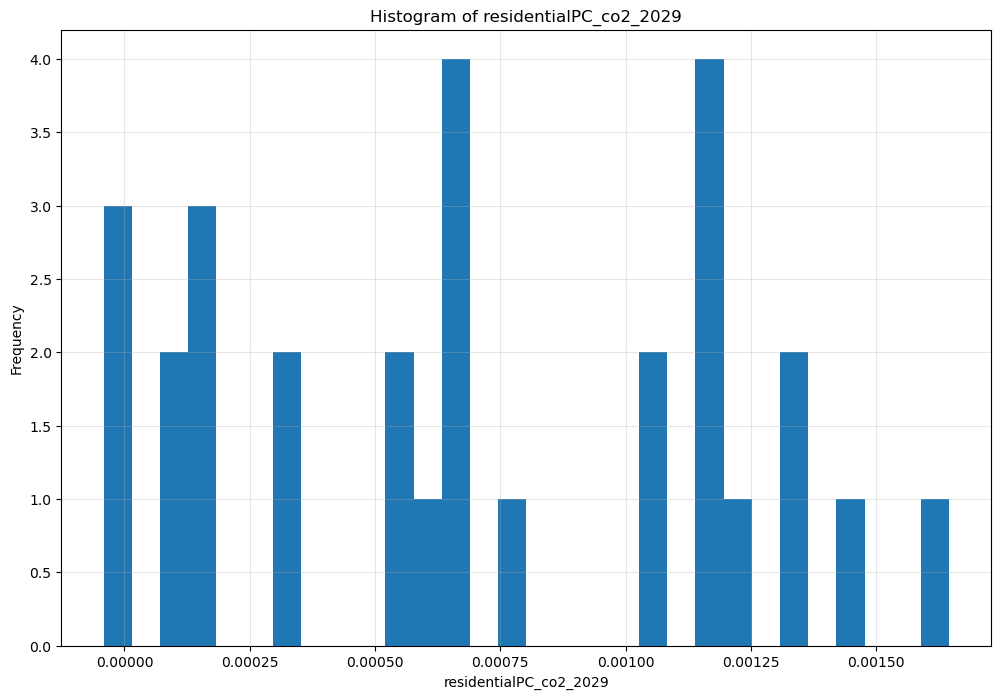

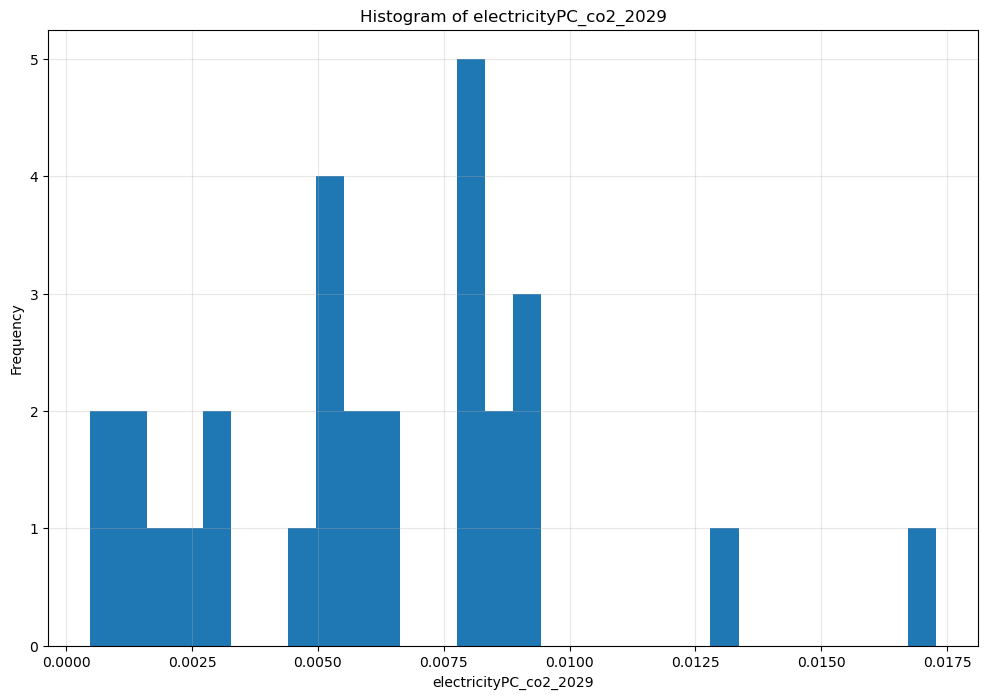

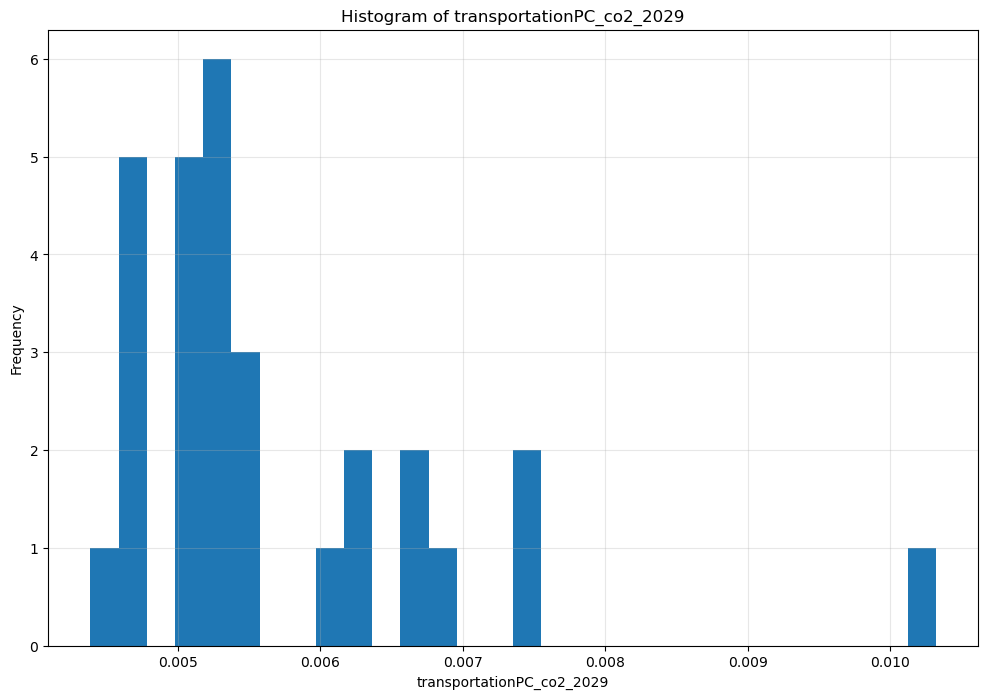

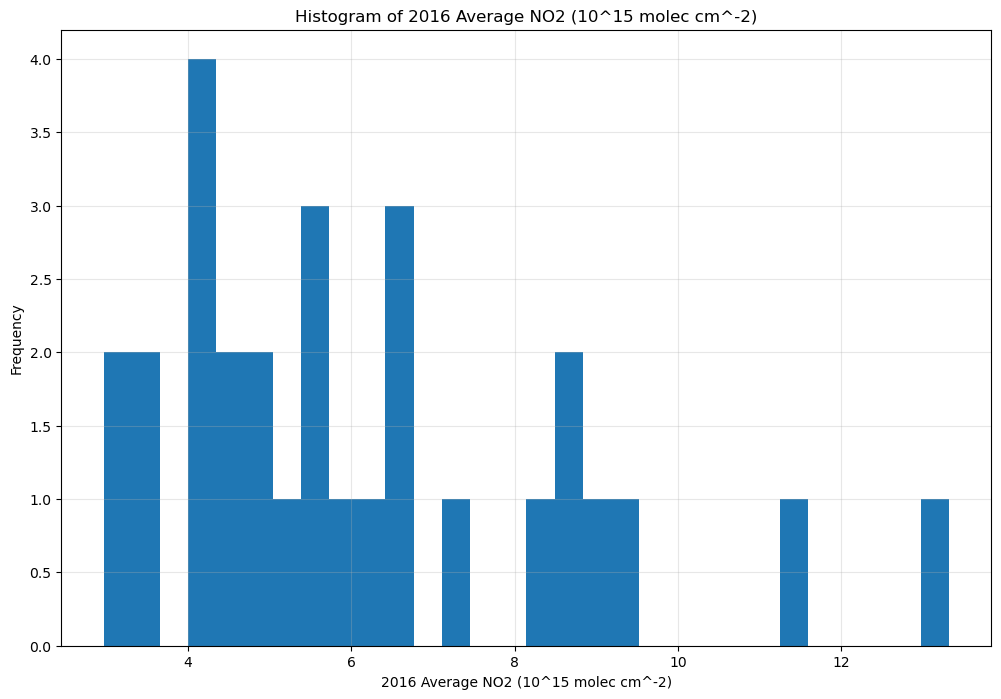

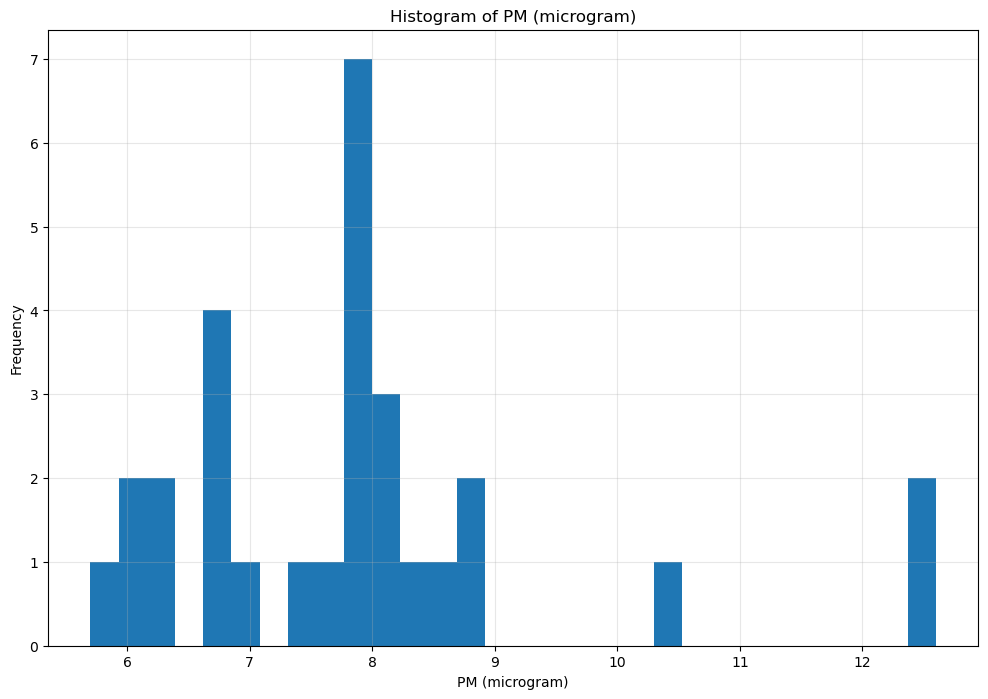

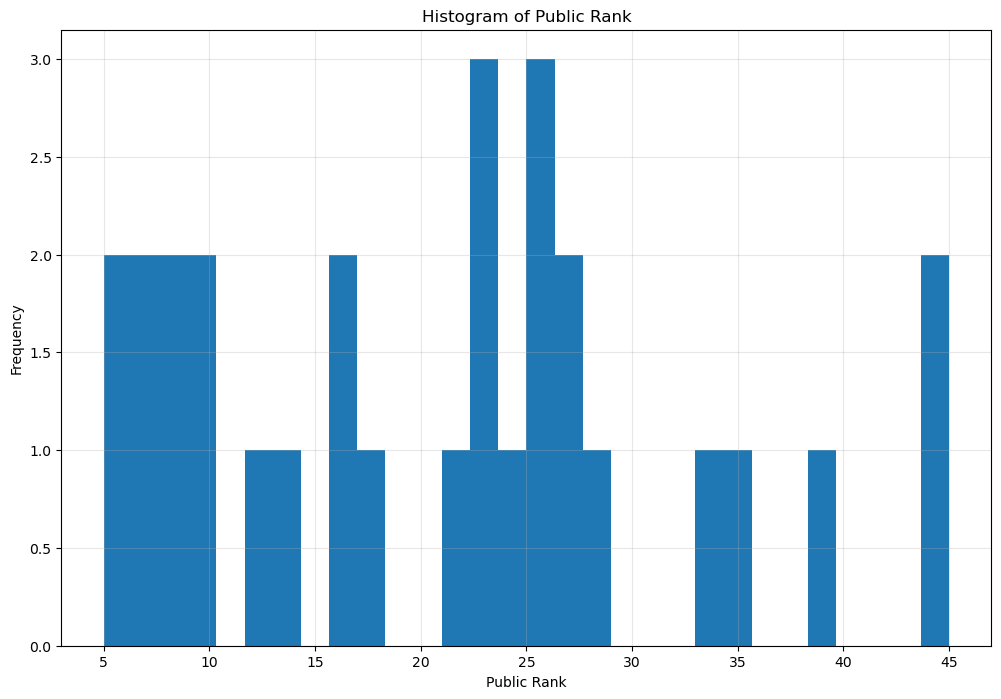

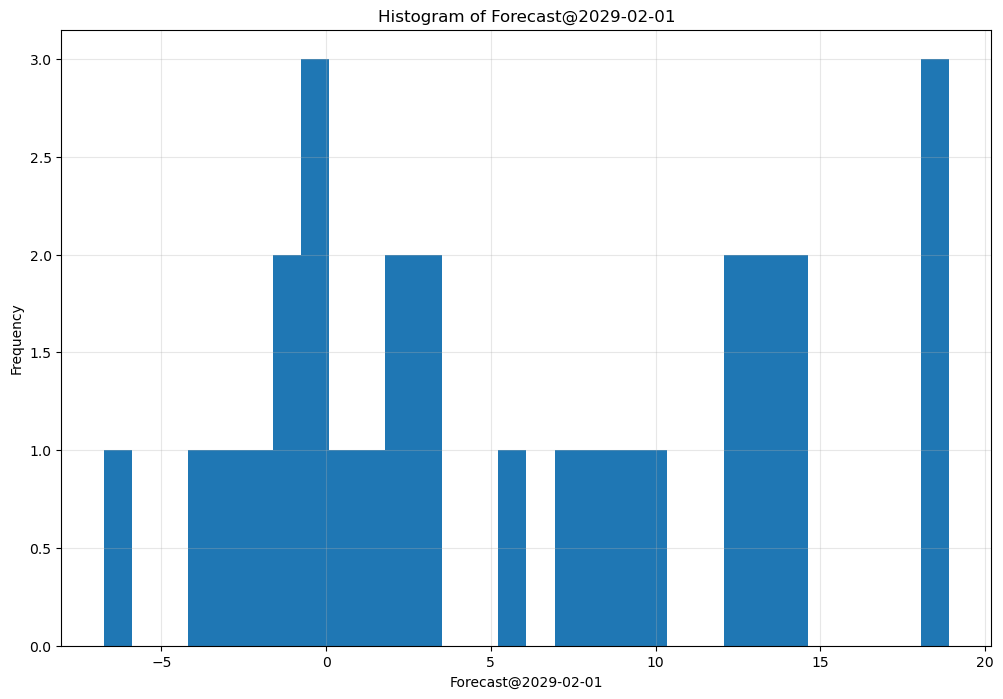

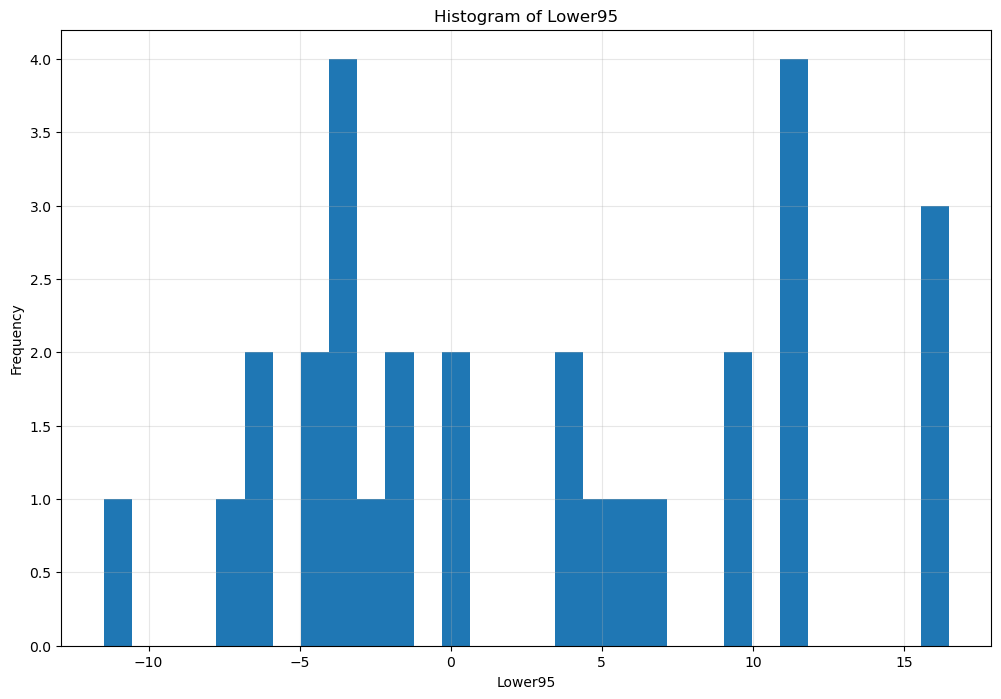

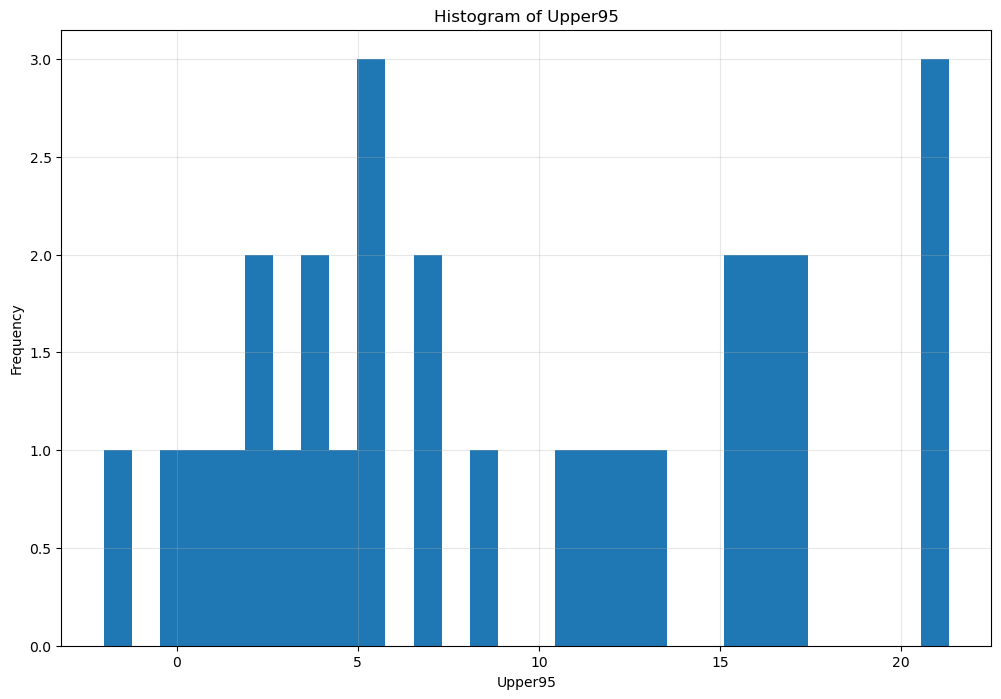

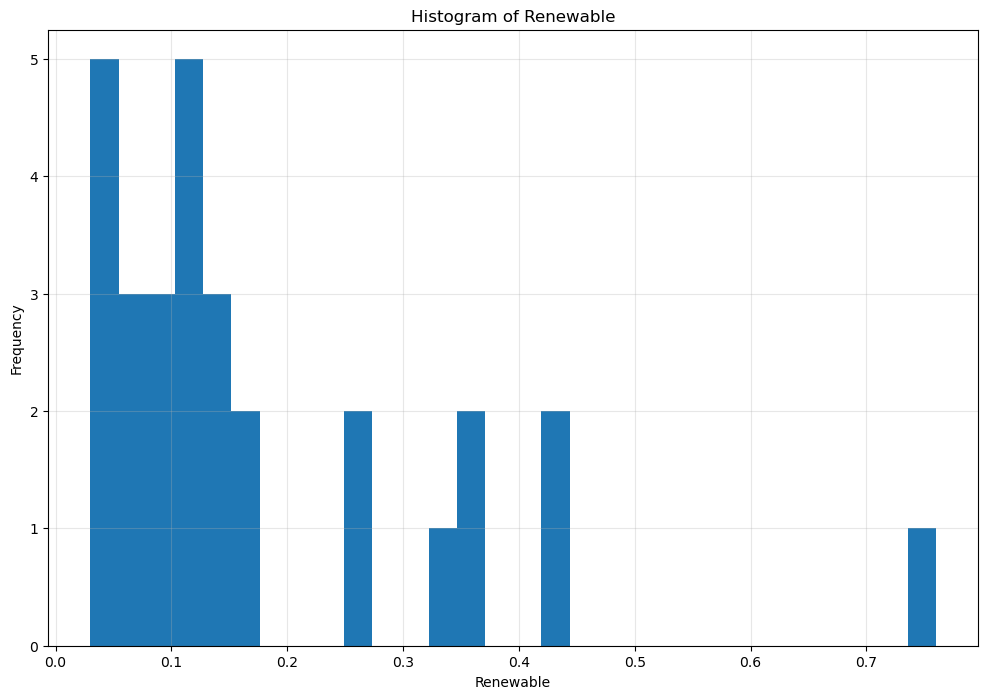

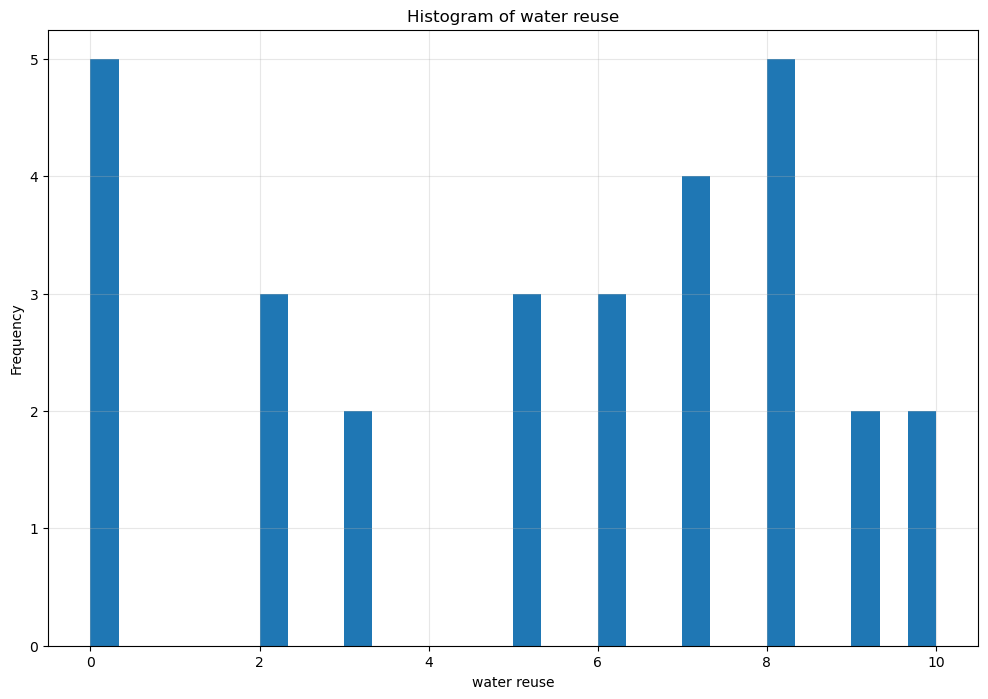

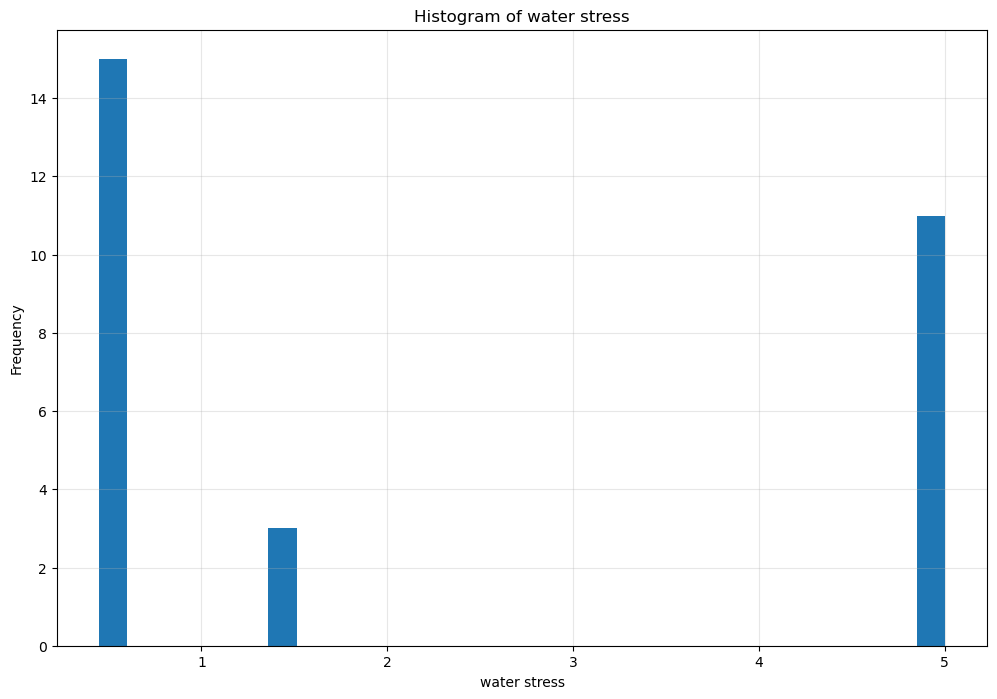

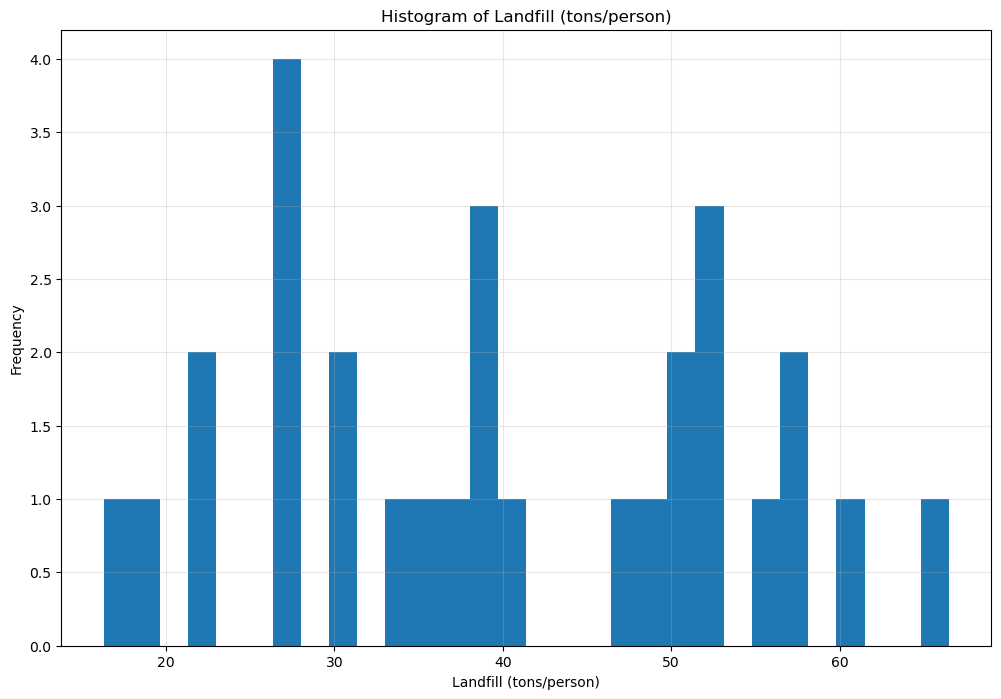

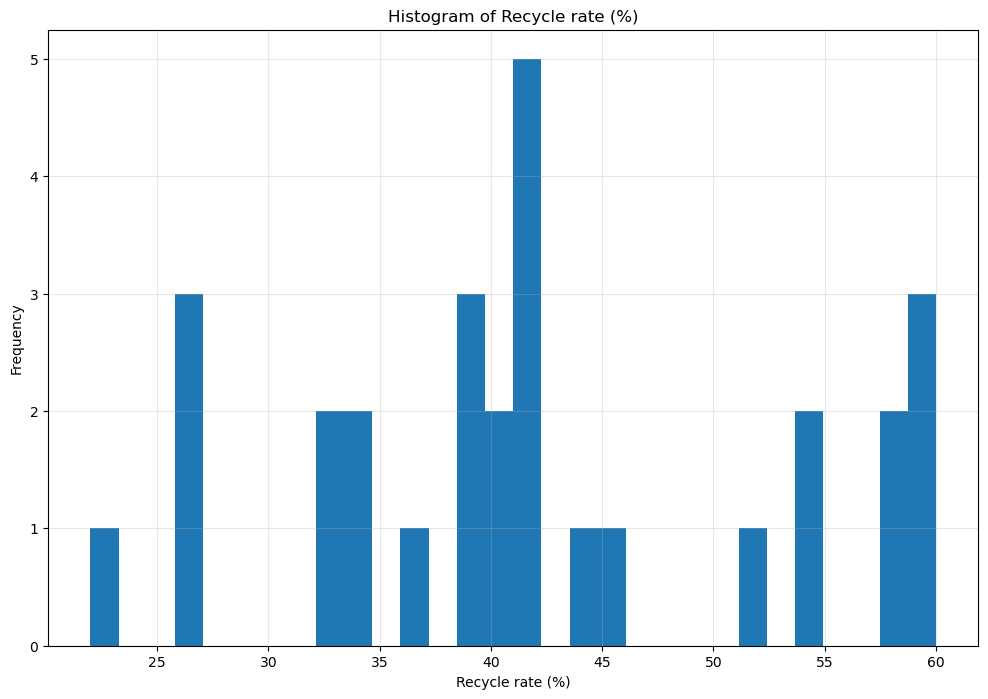

In [144]:
plot_all_histograms(df)

In [145]:
# Perform weighted TOPSIS
def weighted_topsis(df, criteria, weights, impacts):
    """
    Args:
        - df : pandas.DataFrame
            Input dataset. Must contain all columns in 'criteria'.
        - criteria : list of str
            Column names to use as MCDA criteria.
        - weights : list of float
            Corresponding weights for each criterion (will be normalized internally).
        - impacts : list of str
            '+' means benefit criterion, '-' means cost criterion.

    Returns:
        - pandas.DataFrame
            Original DF with added columns:
            - 'topsis_score'
            - 'rank'
    """

    X = df[criteria].astype(float).to_numpy()
    weights = np.array(weights)
    weights = weights / weights.sum()
    norm = np.linalg.norm(X, axis=0)
    R = X / norm
    V = R * weights
    ideal_best = []
    ideal_worst = []

    for i, impact in enumerate(impacts):
        if impact == '+':
            ideal_best.append(V[:, i].max())
            ideal_worst.append(V[:, i].min())
        else:
            ideal_best.append(V[:, i].min())
            ideal_worst.append(V[:, i].max())

    # Compute using Euclidean distance
    ideal_best = np.array(ideal_best)
    ideal_worst = np.array(ideal_worst)
    dist_best = np.linalg.norm(V - ideal_best, axis=1)
    dist_worst = np.linalg.norm(V - ideal_worst, axis=1)
    score = dist_worst / (dist_best + dist_worst)
    df["topsis_score"] = score
    df["rank"] = df["topsis_score"].rank(ascending=False).astype(int)

    return df.sort_values("rank")

# One-Time Test

In [146]:
# Running the TOPSIS for all states
criteria = [
    "residentialPC_co2_2029",
    "electricityPC_co2_2029",
    "transportationPC_co2_2029",
    "2016 Average NO2 (10^15 molec cm^-2)",
    "PM (microgram)",
    "Public Rank",
    "Renewable",
    "water reuse",
    "water stress",
    "Landfill (tons/person)",
    "Recycle rate (%)"
]

# Weights
weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.15, 0.05, 0.05, 0.1, 0.05]

# Impacts: '+' = good for environment, '-' = bad for environment
impacts = [
    '-',  # CO2 residential
    '-',  # CO2 electricity
    '-',  # CO2 transportation
    '-',  # NO2
    '-',  # PM
    '+',  # Public rank (higher rank = better)
    '+',  # Renewable energy %
    '+',  # water reuse
    '-',  # water stress
    '-',  # landfill waste
    '+'   # recycle rate
]

result = weighted_topsis(df, criteria, weights, impacts)

print(result[['state', 'topsis_score', 'rank']])


             state  topsis_score  rank
27      Washington      0.798125     1
2       California      0.626460     2
1       California      0.576423     3
18          Nevada      0.550041     4
16       Minnesota      0.491579     5
3         Colorado      0.490566     6
25           Texas      0.477448     7
26           Texas      0.474186     8
14   Massachusetts      0.447556     9
19  North Carolina      0.439450    10
0          Arizona      0.432590    11
5          Florida      0.429130    12
6          Florida      0.426777    13
4          Florida      0.426581    14
24       Tennessee      0.417396    15
13   Massachusetts      0.412755    16
12        Maryland      0.400985    17
7          Georgia      0.394592    18
11        Maryland      0.390820    19
10       Louisiana      0.372781    20
17        Missouri      0.349685    21
28       Wisconsin      0.329871    22
8         Illinois      0.316505    23
15        Michigan      0.308607    24
9          Indiana      0

# Sensitivity Test

In [147]:
# Perform SOBOL sensitivity test
def solbol_test(df, criteria, impacts, n_samples=1000):
    """
    Args:
        - df : pandas.DataFrame
            The dataset.
        - criteria : list of str
            List of criteria columns.
        - impacts : list of str
            '+' or '-' signs for each criterion.
        - n_samples : int
            Number of Sobol samples (Saltelli). Default = 1000.

    Returns:
        - sobol_results : dict
            Contains Sobol first-order, second-order, and total indices.
        - sample_scores : np.ndarray
            Array of TOPSIS scores for the Sobol sample runs.
        - state_rankings : pd.DataFrame
            Ranking frequency of each state across all samples.
    """

    k = len(criteria)
    problem = {
        "num_vars": k,
        "names": criteria,
        "bounds": [[0, 1]] * k
    }
    sample_matrix = saltelli.sample(problem, n_samples)
    sample_matrix = sample_matrix / sample_matrix.sum(axis=1, keepdims=True)
    scores = []
    ranking_records = []

    for weights in sample_matrix:
        tmp_df = df.copy()
        tmp = weighted_topsis(tmp_df, criteria, weights, impacts)

        scores.append(tmp.iloc[0]["topsis_score"])
        ranking_records.append(tmp.iloc[0]["state"])

    scores = np.array(scores)
    sobol_results = sobol.analyze(problem, scores, print_to_console=False)
    ranking_df = pd.DataFrame(ranking_records, columns=["state"])
    ranking_freq = ranking_df.value_counts(normalize=True).rename("probability").reset_index()

    return sobol_results, scores, ranking_freq

In [148]:
# Runing SOBOL test
sobol_results, sample_scores, ranking_distribution = solbol_test(
    df=df,
    criteria=criteria,
    impacts=impacts,
    n_samples=1000
)

print("Sobol First-order indices:")
print(pd.DataFrame(sobol_results['S1'], index=criteria, columns=["S1"]))
print("\nState probability of being ranked #1 across all samples:")
print(ranking_distribution)


/tmp/ipykernel_3522167/4007070025.py:29: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  sample_matrix = saltelli.sample(problem, n_samples)
/run/media/pooh555/Anaconda/miniconda3/HIMCM/lib/python3.13/site-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Sobol First-order indices:
                                            S1
residentialPC_co2_2029                0.019593
electricityPC_co2_2029                0.061536
transportationPC_co2_2029            -0.003090
2016 Average NO2 (10^15 molec cm^-2) -0.000809
PM (microgram)                        0.017754
Public Rank                           0.661655
Renewable                             0.116749
water reuse                           0.010104
water stress                          0.011771
Landfill (tons/person)               -0.005854
Recycle rate (%)                     -0.001978

State probability of being ranked #1 across all samples:
             state  probability
0       Washington     0.699125
1   North Carolina     0.071583
2       California     0.067250
3          Florida     0.037167
4            Texas     0.035500
5        Tennessee     0.024000
6          Georgia     0.019542
7    Massachusetts     0.015625
8          Arizona     0.012000
9        Louisiana     0.008083

# Redundancy Test

In [149]:
# Perform redundancy test
def redundancy_test(df, criteria, weights, impacts):
    """
    Args:
        - df : pandas.DataFrame
            The dataset.
        - criteria : list of str
            List of all criteria used in TOPSIS.
        - weights : list of float
            Full weight vector matching all criteria.
        - impacts : list of str
            '+' or '-' signs for each criterion.

    Returns:
        - pd.DataFrame
            A summary table showing:
            - correlation: Spearman correlation between full vs reduced scores
            - avg_rank_shift: Mean rank shift after removing the criterion
            - max_rank_shift: Maximum individual state shift
    """

    # Baseline TOPSIS
    baseline = weighted_topsis(df.copy(), criteria, weights, impacts)
    baseline_scores = baseline["topsis_score"].values
    baseline_ranks = baseline["rank"].values
    states = baseline["state"].values
    results = []

    for i, removed in enumerate(criteria):
        # Build reduced sets
        reduced_criteria = [c for c in criteria if c != removed]
        reduced_impacts = [impacts[j] for j, c in enumerate(criteria) if c != removed]
        reduced_weights = [weights[j] for j, c in enumerate(criteria) if c != removed]

        # Re-normalize weights
        reduced_weights = np.array(reduced_weights)
        reduced_weights = reduced_weights / reduced_weights.sum()

        # Run reduced TOPSIS
        reduced = weighted_topsis(df.copy(), reduced_criteria, reduced_weights, reduced_impacts)

        # Align states
        reduced = reduced.sort_values("state")
        base_sorted = baseline.sort_values("state")

        # Compare scores
        corr, _ = spearmanr(base_sorted["topsis_score"], reduced["topsis_score"])

        # Compare rank shifts
        rank_shift = np.abs(base_sorted["rank"] - reduced["rank"])
        avg_shift = rank_shift.mean()
        max_shift = rank_shift.max()

        # Store result
        results.append({
            "removed_criterion": removed,
            "correlation": corr,
            "avg_rank_shift": avg_shift,
            "max_rank_shift": max_shift
        })

    return pd.DataFrame(results).sort_values("correlation")


In [150]:
redundancy_results = redundancy_test(
    df=df,
    criteria=criteria,
    weights=weights,
    impacts=impacts
)

print("Redundancy Analysis:\n")
print(redundancy_results)


Redundancy Analysis:

                       removed_criterion  correlation  avg_rank_shift  \
6                              Renewable     0.646798        5.931034   
0                 residentialPC_co2_2029     0.954187        1.793103   
1                 electricityPC_co2_2029     0.958621        1.655172   
3   2016 Average NO2 (10^15 molec cm^-2)     0.967583        0.931034   
2              transportationPC_co2_2029     0.968966        0.206897   
5                            Public Rank     0.974877        0.275862   
4                         PM (microgram)     0.994089        0.137931   
8                           water stress     0.994704        0.379310   
9                 Landfill (tons/person)     0.998030        0.206897   
7                            water reuse     0.999507        0.068966   
10                      Recycle rate (%)     0.999507        0.068966   

    max_rank_shift  
6               14  
0                7  
1                5  
3                